In [ ]:
from analysis import Bittrex

In [ ]:
# instance olusturuyoruz
analysis = Bittrex()

# kullanılabilecek metodlar: 
#     .get_summary('eth')
#     .tick('eth')
#     .get_market()
#     .get_orderbook('eth')
#     .orderbook_analysis('eth', sample=10)
#     .plot('eth', loop=0, sleep=5)

In [ ]:
# ilgili coin icin request anindaki son degerleri getirir
analysis.get_summary('eth')

In [ ]:
# coin icin son - alis/satis talimatinin deger bilgilerini getirir
# not : get_summary metodundaki verilerle aynidir
ab = ['dgb', 'snt', 'vrm', 'amp', 'pink']
[{ a: analysis.tick(a)}  for a in ab]

In [ ]:
# Bittrex uzerindeki tum coinlerin market bilgilerini getirir
analysis.get_market()

In [ ]:
# verilen coin icin o an acik olan tum alis/satis talimalarini gosterir. 
# Quantity: coinden kac adet oldugu, Rate: BTC cinsinden talimat degeri
analysis.get_orderbook('eth')

In [ ]:
# orderbook uzerinden bir deger analizi cikarilir. sample sayisi kadar son orderlar, 
# bunlarin toplami ve sample sayisi kadar orderin grafik egri degeri hesaplanir
analysis.orderbook_analysis('eth', sample=10)

In [ ]:
# coin icin anlik alis-satis talimatlari ve deger bilgileri grafigi yazdirilir. 
# loop = 0 : surekli ekrana basar, 
# loop = N : N saniye kadar calisir
# sleep = N : her bir request icin N saniye kadar bekler
analysis.plot('dgb', loop=100, sleep=3)

In [ ]:
analysis.plot_file('mtl', path='data/')

In [16]:
#!/usr/bin/env python3.6

import requests, json, time, hmac, hashlib
from matplotlib import pyplot as plt
from multiprocessing import Manager, Process
import os
from pandas import read_csv
plt.rcParams['figure.figsize'] = (16,4)
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
from collections import Counter
import warnings; warnings.simplefilter('ignore')
output_notebook()

class Bittrex(object):
    def __init__(self, auth_info=None):
        self.key    = auth_info and auth_info['key']
        self.secret = auth_info and auth_info['secret']
        self.uri    = 'https://bittrex.com/api/v1.1'

    def get_request(self, url, sign):
        return requests.get(url, headers={'apisign': sign}).json()
    
    def infinity(self): 
        while True: 
            yield
    
    def colors(self):
        return ['darkred', 'darkolivegreen', 'darkkhaki', 'teal', 
                'seagreen', 'darkorange', 'dodgerblue', 'darkblue', 'magenta', 'black']
    
    def scale(self, data, minX, maxX):
        scaler = MinMaxScaler(feature_range=(minX, maxX), copy=False)
        scaler.fit(data.reshape(-1, 1))
        return scaler.transform(data.reshape(-1, 1)).reshape(-1)
    
    def dispatch(self, output, result_only=True, index=None):
        if index:
            return output.json()['result'][index] if result_only else output.json()
        else:
            return output.json()['result'] if result_only else output.json()
        
    
    def get_balance(self, all=False, result_only=True):
        url    = self.uri + '/account/getbalances?apikey={}&nonce={}'.format(self.key, time.time())
        sign   = hmac.new(self.secret.encode(), url.encode(), hashlib.sha512).hexdigest()
        result = self.get_request(url, sign)
        
        if result_only:
            return result['result'] if all else list(filter(lambda x: x['Balance'] > 0, result['result']))
        else:
            return result if all else {'message': result['message'], 
                                   'success': result['success'], 
                                   'result': list(filter(lambda x: x['Balance'] > 0, result['result']))}
    
    def get_summary(self, c='vrm', base='btc', result_only=True):
        return self.dispatch(
            requests.get(self.uri + '/public/getmarketsummary?market={}-{}'.format(base, c)), 
            result_only=result_only, index=0)
        
    
    def tick(self, c='vrm', base='btc', result_only=True):
        return self.dispatch(
            requests.get(self.uri + '/public/getticker?market={}-{}'.format(base, c)),
            result_only=result_only)

    def get_coins(self, base='BTC'):
        return list(map(lambda x: x['MarketCurrency'], filter(lambda y: 
                           y['BaseCurrency'] == base.upper(), 
                           requests.get(self.uri + '/public/getmarkets/').json()['result'])))
    
    
    def get_market(self, result_only=True):
        return self.dispatch(
            requests.get(self.uri + '/public/getmarkets/'),
            result_only)
    
    def get_markethistory(self, c='vrm', base='btc', result_only=True):
        return self.dispatch(
            requests.get(self.uri + '/public/getmarkethistory?market={}-{}&type=both'.format(base, c)),
            result_only)
    
    def get_orderbook(self, c='vrm', base='btc', result_only=True):
        return self.dispatch(
            requests.get(self.uri + '/public/getorderbook?market={}-{}&type=both'.format(base, c)),
            result_only)
    
    def orderbook_analysis(self, c='vrm', base='btc', sample=10):
        def get_score(arr):
            total_diff = 0
            for i in range(len(arr)-1):
                slope = abs(1/(arr[i+1] - arr[i]))
                total_diff += slope
            return total_diff
        
        orderbook = self.get_orderbook(c=c, base=base, result_only=True)
        
        total_buy_orders = 0
        buy_order_list   = []
        for buy_order in orderbook['buy'][:sample]: # {'Quantity/Size(ETH)': 2.26034925, 'Rate/Bid(BTC)': 0.04627} 
            quantity           = buy_order['Quantity']
            bid                = buy_order['Rate']
            buy_order_in_btc   = quantity * bid
            total_buy_orders   += buy_order_in_btc
            buy_order_list.append(total_buy_orders)
        
        total_sell_orders = 0
        sell_order_list   = []
        for sell_order in orderbook['sell'][:sample]: # {'Quantity/Size(ETH)': 2.26034925, 'Rate/Ask(BTC)': 0.04627} 
            quantity           = sell_order['Quantity']
            ask                = sell_order['Rate']
            sell_order_in_btc  = quantity * ask
            total_sell_orders  += sell_order_in_btc
            sell_order_list.append(total_sell_orders)
        
        return {'total_buy_orders': total_buy_orders,
                'total_sell_orders': total_sell_orders,
                'buy_orders': buy_order_list,
                'sell_orders': sell_order_list,
                'buy_order_slope': get_score(buy_order_list),
                'sell_order_slope': get_score(sell_order_list)}
    
    # all = True for all coins, all = ['ETH', 'VRM', ..] for specific coins
    # loop = 0 for a infinite loop, loop = 5 for 5 loops
    # sleep = 60 for a 60 second sleep time between two requests
    def write_serial(self, all=True, loop=0, sleep=60, folder=''):
        while True:
            try:
                coinlist = self.get_coins() if all == True else all
                loop = self.infinity() if loop == 0 else range(loop)

                for coin in coinlist:
                    coin     = coin.upper()
                    filepath = '{}{}.csv'.format(folder, coin)

                    if not os.path.isfile(filepath):

                        f = open(filepath, 'w')
                        f.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(
                            "timestamp", "tick", "ask", "bid", "vol", "buys", 
                            "sells", "btc_tick", "btc_buys", "btc_sells", "btc_vol", "usdt",
                            "first_page_buy_orders", "first_page_sell_orders"))

                    for i in loop:
                        f = open(filepath, 'a')

                        coin_summary = self.get_summary(coin)[0]
                        timestamp    = coin_summary['TimeStamp']
                        tick         = coin_summary['Last']
                        ask          = coin_summary['Ask']
                        bid          = coin_summary['Bid']
                        vol          = coin_summary['BaseVolume']
                        buys         = coin_summary['OpenBuyOrders']
                        sells        = coin_summary['OpenSellOrders']

                        btc_market   = self.get_summary('btc', base='usdt')[0]
                        btc_tick     = btc_market['Last']
                        btc_buys     = btc_market['OpenBuyOrders']
                        btc_sells    = btc_market['OpenSellOrders']
                        btc_vol      = btc_market['Volume']

                        usdt         = tick * btc_tick
                        
                        try:
                            order_book   = self.orderbook_analysis(coin)
                            first_page_buy_orders = order_book['total_buy_orders']
                            first_page_sell_orders = order_book['total_sell_orders']
                        except:
                            first_page_buy_orders = 0
                            first_page_sell_orders = 0
                        

                        f.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(
                            timestamp, tick, ask, bid, vol, buys, 
                            sells, btc_tick, btc_buys, btc_sells, btc_vol, 
                            usdt, first_page_buy_orders, first_page_sell_orders))

                        f.close()
                        time.sleep(sleep)
            except Exception as e:
                print(e)
                time.sleep(30)
    
    def write(self, all=True, loop=0, sleep=60, folder=''):
        coinlist = self.get_coins() if all == True else all        
        
        jobs = []
        for coin in coinlist:
            thread = Process(target=self.write_serial, args=([coin], loop, sleep, folder))
            jobs.append(thread)
        
        for j in jobs:
            try:
                j.start()
            except:
                j.start()
            
        for j in jobs:
            j.join()

        
        
    def plot(self, c='vrm', base='btc', loop=0, sleep=10):
        try:
            from IPython.display import clear_output
            plt.rcParams['figure.figsize'] = (16,4)
        except:
            raise("This method only works on IPython notebook!")
            
        coin         = c.upper()
        loop         = self.infinity() if loop == 0 else range(loop)
        
        tick, ask, bid = [], [], []
        for i in loop:
            clear_output(wait=True)
            coin_summary = self.get_summary(coin, base=base)[0]
            
            tick.append(coin_summary['Last'])
            ask.append(coin_summary['Ask'])
            bid.append(coin_summary['Bid'])
            
            plt.plot(ask, color='r', label='ask')
            plt.plot(bid, color='g', label='bid')
            plt.plot(tick, color='b', label='tick')
            plt.legend()
            plt.show()
            
            time.sleep(sleep)
        
    def plot_btc(self, loop=0, sleep=10):
        import requests
        from lxml import html
        
        prices       = []
        loop         = self.infinity() if loop == 0 else range(loop)
        for i in loop:
            clear_output(wait=True)
            prices.append(float( html.fromstring(requests.get("http://koinim.com").text).cssselect(".nav-BTC-price")[0].text ))
            plt.plot(prices[:])
            plt.show()
            time.sleep(sleep)
            
            
    def plot_file(self, c='vrm', path='data/', last=1000, density=1, outfile=False):
        if outfile:
            output_file("prediction.html", title="prediction")
        data = read_csv('{}{}.csv'.format(path,c.upper()), header=0, index_col=0)
        headers       = [i for i in data.axes[1]]
        data = data.values
        

        x = [i for i in range(data.shape[0])]
        
        

        plottick = figure(title='tick analysis', x_axis_label='time (1min per dot)', y_axis_label='value', 
                        width=950, height=300, sizing_mode='scale_width', 
                        tools = "xwheel_zoom,undo,redo,xpan,save,reset,hover,box_zoom",active_scroll="xwheel_zoom")
    
        x_tick = data[:,0].copy()
        x_ask  = data[:,1]
        x_sell = data[:,2]

        plottick.line(x, x_tick[-last::density], legend='tick', line_width=2, line_color='blue', alpha=0.8)
        plottick.line(x, x_ask[-last::density], legend='ask', line_width=1, line_color='red', alpha=0.8)
        plottick.line(x, x_sell[-last::density], legend='bid', line_width=1, line_color='green', alpha=0.8)

        
        ################################
        
        
        plotvol = figure(title='volume analysis', x_axis_label='time (1min per dot)', y_axis_label='value', 
                        width=950, height=300, sizing_mode='scale_width', 
                        tools = "xwheel_zoom,undo,redo,xpan,save,reset,hover,box_zoom",active_scroll="xwheel_zoom")

        minvol = data[:,4].min() if data[:,4].min() < data[:,5].min() else data[:,5].min()
        maxvol = data[:,4].max() if data[:,4].max() > data[:,5].max() else data[:,5].max()
    
    
        vol_tick = data[:,0].copy()
        vol_tick = self.scale(vol_tick, minvol, maxvol)
        
        plotvol.line(x, vol_tick[-last::density], legend='tick', line_width=2, line_color='blue', alpha=0.8)
        plotvol.line(x, data[:,4][-last::density], legend='buys', line_width=1, line_color='green', alpha=0.8)
        plotvol.line(x, data[:,5][-last::density], legend='sells', line_width=1, line_color='red', alpha=0.8)
        
        
        ################################
        
        
        plot1stpage = figure(title='1st page analysis', x_axis_label='time (1min per dot)', y_axis_label='value', 
                        width=950, height=300, sizing_mode='scale_width', 
                        tools = "xwheel_zoom,undo,redo,xpan,save,reset,hover,box_zoom",active_scroll="xwheel_zoom")
        
        minvol1stpage = data[:,11].min() if data[:,11].min() < data[:,12].min() else data[:,12].min()
        maxvol1stpage = data[:,11].max() if data[:,11].max() > data[:,12].max() else data[:,12].max()
        
        
        firstpage_tick = data[:,0].copy()
        firstpage_tick = self.scale(firstpage_tick, minvol1stpage, maxvol1stpage)
        
        plot1stpage.line(x, firstpage_tick[-last::density], legend='tick', line_width=2, line_color='blue', alpha=0.8)
        plot1stpage.line(x, data[:,11][-last::density], legend='1st page buys', line_width=1, line_color='green', alpha=0.8)
        plot1stpage.line(x, data[:,12][-last::density], legend='1st page sells', line_width=1, line_color='red', alpha=0.8)

        grid = gridplot([[plottick], [plotvol], [plot1stpage]])
        
        plottick.legend.location = "top_left"
        plottick.legend.click_policy="hide"
        
        plotvol.legend.location = "top_left"
        plotvol.legend.click_policy="hide"
        
        plot1stpage.legend.location = "top_left"
        plot1stpage.legend.click_policy="hide"
        
        show(grid)
        
    def get(self, c='vrm', column='tick', path='data/', normalize=False, last=None, density=1):
        data = read_csv('{}{}.csv'.format(path,c.upper()), header=0)
        headers       = [i for i in data.axes[1]]
        data = data.values
        last = last if last else 0
        
        if column == 'timestamp'  : return data[-last::density,0] if not normalize else self.scale(data[-last::density,0], 0, 1)
        if column == 'tick'       : return data[-last::density,1] if not normalize else self.scale(data[-last::density,1], 0, 1)
        if column == 'ask'        : return data[-last::density,2] if not normalize else self.scale(data[-last::density,2], 0, 1)
        if column == 'bid'        : return data[-last::density,3] if not normalize else self.scale(data[-last::density,3], 0, 1)
        if column == 'vol'        : return data[-last::density,4] if not normalize else self.scale(data[-last::density,4], 0, 1)
        if column == 'buys'       : return data[-last::density,5] if not normalize else self.scale(data[-last::density,5], 0, 1)
        if column == 'sells'      : return data[-last::density,6] if not normalize else self.scale(data[-last::density,6], 0, 1)
        
        if column == 'btc_tick'   : return data[-last::density,7] if not normalize else self.scale(data[-last::density,7], 0, 1)
        if column == 'btc_buys'   : return data[-last::density,8] if not normalize else self.scale(data[-last::density,8], 0, 1)
        if column == 'btc_sells'  : return data[-last::density,9] if not normalize else self.scale(data[-last::density,9], 0, 1)
        if column == 'btc_vol'    : return data[-last::density,10] if not normalize else self.scale(data[-last::density,10], 0, 1)
        
        if column == 'usdt'       : return data[-last::density,11] if not normalize else self.scale(data[-last::density,11], 0, 1)
        if column == 'first_page_buy_orders'  : return data[-last::density,12] if not normalize else self.scale(data[-last::density,12], 0, 1)
        if column == 'first_page_sell_orders' : return data[-last::density,13] if not normalize else self.scale(data[-last::density,13], 0, 1)
            
    
    def plot_vol_dif(self, c='vrm', normalize=False, density=1, last=None):

        vol = self.get(c, 'vol')[::-1]
        tick = self.get(c, 'tick')[::-1]

        vol_diffs  = []
        tick_diffs = []
        vol_val1, vol_val2 = 0, 0
        tick_val1, tick_val2 = 0, 0
        for i in range(len(tick) - density):
            vol_val1  += math.sqrt( abs( vol[i]**2 - vol[i+density]**2 ))
            vol_val2  += vol[i] - vol[i+density]
            
            tick_val1 += math.sqrt( abs( tick[i]**2 - tick[i+density]**2 ))
            tick_val2 += tick[i] - tick[i+density]
            
            vol_diffs.append( vol_val2 )
            tick_diffs.append( tick_val2 )
            
        vol_diffs = self.scale(np.array(vol_diffs), 0, 1) if normalize else vol_diffs
        tick_diffs = self.scale(np.array(tick_diffs), 0, 1) if normalize else tick_diffs
        
        
        plt.plot(self.scale(np.array(vol_diffs[:last]), 0, 1), label=c+' - diffs')
        plt.plot(self.scale(np.array(tick_diffs[:last]), 0, 1), label=c+' - ticks')
        plt.legend()
        plt.show()
        
    def similar_patterns(self, c='vrm', last=5000, density=1):
        column = 'tick'
        if c.upper() == 'BTC':
            c = 'vrm'
            column = 'btc_tick'
            
        c_tick = self.get(c=c, column=column, path='data/', normalize=True, last=last, density=density)
        similarities = []
        for i in self.get_coins():
            if i.upper() != c.upper():
                i_tick = self.get(c=i, column='tick', path='data/', normalize=True, last=last, density=density)
                diff = (c_tick - i_tick)**2
                similarities.append({'coin': i, 'mse': sum(diff) / last})
        return sorted(np.array(similarities), key=lambda k: k['mse'], reverse=False)
        
    
    
    def analysis(self, last=5000, density=1):
        coins = self.get_coins()
        
        increasing_volumes = []
        increasing_buys = []
        
        for c in coins:
            volume = self.get(c=c, column='vol', normalize=True)[-last::density]
            voldiff = volume[-1] - volume[0]
            if voldiff > 0 and voldiff < 1:
                increasing_volumes.append({'coin': c, 'voldiff': voldiff})
        
            buys = self.get(c=c, column='buys', normalize=True)[-last::density]
            buysdiff = buys[-1] - buys[0]
            if buysdiff > 0 and buysdiff < 1:
                increasing_buys.append({'coin': c, 'buysdiff': buysdiff})
            
            
        return { 
            'increasing_volumes': sorted(increasing_volumes, key=lambda k: k['voldiff'], reverse=True),
            'increasing_buys'   : sorted(increasing_buys, key=lambda k: k['buysdiff'], reverse=True)}
            

    def plot_multi(self, coins=None, types=None, last=5000, density=1, normalize=True, plot='plt'):
        """
            plot_multi:
                plots given coins into one graph together according to given multiple types.

            example usage:
                a.plot_multi(coins=['dgb','vrm','btg'], types=['tick', 'vol'], 
                             last=1000, density=1, normalize=True, plot='bokeh')
                args:
                    coins*    : [str]       Default: None     [coin shortnames]
                    types*    : [str]       Default: None     [record types: 'tick', 'vol', 'buys', 'sells', 'usdt'...]
                    last      : int         Default: 5000     [last N points will be shown]
                    density   : int         Default: 1        [tick density]
                    normalize : Boolean     Default: False    [normalize all the values between 0-1]
                    plot      : str         Default: 'plt'    [plt: static graph, bokeh: dynamic graph]

        """
        if plot == 'plt':
            for c in coins:
                for t in types:
                    plt.plot(self.get(c,column=t, normalize=normalize, last=last, density=density), label='{}_{}'.format(c,t))
            plt.legend()
            plt.show()
        else:
            plotit = figure(title='analysis', x_axis_label='time', y_axis_label='value', 
                            width=950, height=350, sizing_mode='scale_width', 
                            tools = "xwheel_zoom,undo,redo,xpan,save,reset,hover,box_zoom",active_scroll="xwheel_zoom")


            x = [i for i in range(len(self.get(coins[0],column=types[0], normalize=normalize, last=last, density=density)))]
            
            iters = 0
            for c in coins:
                for t in types:
                    plotit.line(x, self.get(c,column=t, normalize=normalize, last=last, density=density), 
                                 legend='{}_{}'.format(c,t), line_width=1, alpha=0.9, line_color=self.colors()[iters%10])
                    iters += 1
                    
            plotit.legend.location = "top_left"
            plotit.legend.click_policy="hide"
            show(plotit)
    
        

Loading BokehJS ...

In [17]:
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = (16,4)

In [18]:
b = Bittrex()

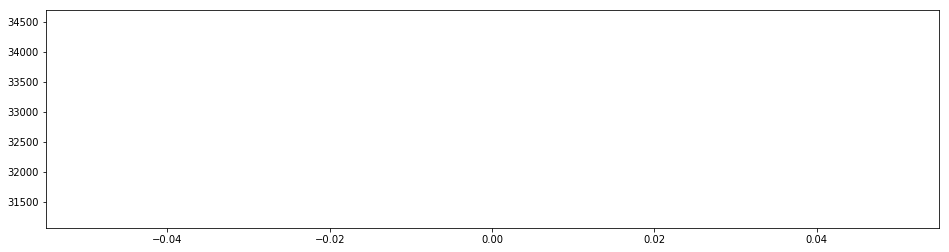

KeyboardInterrupt: 

In [21]:
b.plot_btc(loop=100, sleep=30)

In [22]:
b.plot_multi(coins=['dope', 'gcr', 'mona', 'omg', 'ptoy', 'sc', 'storj', 'strat', 'vrm', 'gup', 'dcr'],
             types=['tick'], density=12, last=2*60*24*2, plot='bokeh', normalize=True)

In [23]:
b.tick('ltc')['Last']

0.01823205

In [24]:
b.plot_multi(coins=['ltc',], types=[
                 'tick',
#                 'vol',
                 #'first_page_buy_orders', 
                 #'first_page_sell_orders'
             ], density=1, last=2*60*24*1, plot='bokeh', normalize=False)
# bin : 0.2394 = 3600, bit : 0.5977 = 9100, = 0.8371   3jan
# bin : 0.2900 = 4300, bit : 0.6600 = 9700, = 0.95   4jan +%13
# bin : 0.2950 = 4300, bit : 0.7050 = 10700, = 1.00   5jan +%5
# bin : 0.23           bit : 0,90            = 1.13   9jan +%13

In [ ]:
from IPython.display import clear_output
class Analysis(object):
    def __init__(self):
        self.trade = Bittrex()
        self.report  = []
        self.report_flow = []
       
    def scale(self, value, minV, maxV):
        return (value - minV) / ((maxV - minV)*1.0)
       
    def checkone(self, coin):
        history = sorted(self.trade.get_markethistory(coin), key=lambda k: k['TimeStamp'], reverse=False)
        buys  = []
        sells = []
        for hist in history:
            if hist['OrderType'] == 'BUY':
                buys.append(hist['Total'])
            else:
                sells.append(hist['Total'])

        return {'lastid': history[-1], 'val': sum(buys) - sum(sells)}
   
    def get(self, coin, L):
        try:
            history = sorted(self.trade.get_markethistory(coin), key=lambda k: k['TimeStamp'], reverse=False)
            buys  = []
            sells = []
            for hist in history:
                if hist['OrderType'] == 'BUY':
                    buys.append(hist['Total'])
                else:
                    sells.append(hist['Total'])

            L.append({'coin': coin, 'flow': round(sum(buys) - sum(sells),3), 'total': round(sum(buys) + sum(sells),3)})
        except:
            pass
   
    def check(self, coins='all'):  
        coins = self.trade.get_coins() if coins == 'all' else coins
        jobs = []
        with Manager() as manager:
            L = manager.list()
            for coin in coins:
                thread = Process(target=self.get, args=[coin, L])
                thread.start()
                jobs.append(thread)

            for j in jobs:
                j.join()
               
            self.report      = sorted(np.array(L), key=lambda k: k['total'], reverse=True)
            self.report_flow = sorted(np.array(L), key=lambda k: k['flow'], reverse=True)
   
       
    def plot(self, coin, loop=10, sleep=10):
        vol  = []
        flow = []
        for i in range(loop):
            clear_output(wait=True)
            self.check([coin])
            result = self.report[0]
            vol.append(result['total'])
            flow.append(result['flow'])
           
            plt.plot(vol, label='vol')
            plt.plot(flow, label='flow')
            plt.legend()
            plt.show()
            time.sleep(sleep)
       



In [ ]:
a = Analysis()

In [ ]:
a.check()

In [ ]:
a.report_flow

In [ ]:
result_plus = []
result_minus = []
result_vol = []

In [ ]:
for i in range(5):
    clear_output(wait=True)
    a.check()
    a.report_flow[:5], a.report_flow[-5:]
   
    result_plus.append(a.report_flow[0]['coin'])
    result_plus.append(a.report_flow[1]['coin'])
    result_plus.append(a.report_flow[2]['coin'])
    result_plus.append(a.report_flow[3]['coin'])
    result_plus.append(a.report_flow[4]['coin'])
   
   
    result_minus.append(a.report_flow[-1]['coin'])
    result_minus.append(a.report_flow[-2]['coin'])
    result_minus.append(a.report_flow[-3]['coin'])
    result_minus.append(a.report_flow[-4]['coin'])
    result_minus.append(a.report_flow[-5]['coin'])
    
    result_vol.append(a.report[0]['coin'])
    result_vol.append(a.report[1]['coin'])
    result_vol.append(a.report[2]['coin'])
    result_vol.append(a.report[3]['coin'])
    result_vol.append(a.report[4]['coin'])

    print ( Counter(result_plus).most_common()[:5] )
    print ()
    print ( Counter(result_minus).most_common()[-5:] )
    print ()
    print ( Counter(result_vol).most_common()[:5] )
   
   
    time.sleep(15)
    #1 rads, qtum,  / bcc, dash, eth
    #2 bcc, ada, dash, 
    #3 xem, ada, xrp
    #4 

In [ ]:
for i in range(20):
    clear_output(wait=True)
    a.check()
    for j in a.report_flow[:5]:
        print (j)
    print()
    for j in a.report_flow[-5:]:
        print (j)
    print()
    for j in a.report[:5]:
        print (j)
    print()
    time.sleep(15)

In [ ]:
result = []

def one(c, L):
    try:
        total = 0
        for o in b.get_orderbook(c)['sell']:
            total += o['Quantity'] * o['Rate']
        L.append({'c': c, 'sellvol': total})
    except:
        print ('hata')

def func(coins='all'):  
    coins = b.get_coins() if coins == 'all' else coins
    jobs = []
    with Manager() as manager:
        L = manager.list()
        for coin in coins:
            thread = Process(target=one, args=[coin, L])
            thread.start()
            jobs.append(thread)

        for j in jobs:
            j.join()
               
        print(sorted(np.array(L), key=lambda k: k['sellvol'], reverse=True)[:5])

func()

In [ ]:
#plt.plot(list(map(lambda x: x['Price'], b.get_markethistory('bcc'))))
plt.plot(list(map(lambda x: x['Quantity'] * x['Price'], b.get_markethistory('sc'))))

plt.show()

In [ ]:
0.01 / b.tick('dgb')['Last']